# Regression
***
## Set up

In [4]:
import os
import datetime
import time
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import clear_output
from sklearn.model_selection import train_test_split
from sklearn import preprocessing, model_selection, metrics
import copy

from sklearn.compose import TransformedTargetRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score, median_absolute_error
from sklearn.preprocessing import QuantileTransformer, OrdinalEncoder

/home/fraz/anaconda3/envs/mlenv/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [5]:
local_path = 'data/regression/'

path = local_path

# For test train files
train = pd.read_csv(path+'train.csv',  index_col=0)
test = pd.read_csv(path+'test.csv',  index_col=0)

# Setting target
target = 'SalePrice'

In [6]:
train.select_dtypes(['object']).nunique().sort_values(ascending=True).head(60)

Street            2
Alley             2
CentralAir        2
Utilities         2
LandSlope         3
PoolQC            3
PavedDrive        3
GarageFinish      3
BsmtQual          4
ExterQual         4
MasVnrType        4
KitchenQual       4
BsmtCond          4
BsmtExposure      4
Fence             4
MiscFeature       4
LandContour       4
LotShape          4
FireplaceQu       5
Electrical        5
HeatingQC         5
GarageQual        5
GarageCond        5
MSZoning          5
LotConfig         5
BldgType          5
ExterCond         5
BsmtFinType1      6
RoofStyle         6
GarageType        6
Foundation        6
Heating           6
BsmtFinType2      6
SaleCondition     6
Functional        7
RoofMatl          8
HouseStyle        8
Condition2        8
SaleType          9
Condition1        9
Exterior1st      15
Exterior2nd      16
Neighborhood     25
dtype: int64

In [7]:
test.select_dtypes(['object']).nunique().sort_values(ascending=True).head(60)

Utilities         1
Street            2
Alley             2
CentralAir        2
PoolQC            2
MiscFeature       3
LandSlope         3
PavedDrive        3
GarageFinish      3
BsmtQual          4
BsmtCond          4
Electrical        4
ExterQual         4
MasVnrType        4
KitchenQual       4
GarageQual        4
RoofMatl          4
BsmtExposure      4
Fence             4
LandContour       4
LotShape          4
Heating           4
GarageCond        5
HeatingQC         5
FireplaceQu       5
MSZoning          5
LotConfig         5
Condition2        5
ExterCond         5
BldgType          5
BsmtFinType1      6
BsmtFinType2      6
GarageType        6
RoofStyle         6
Foundation        6
SaleCondition     6
Functional        7
HouseStyle        7
Condition1        9
SaleType          9
Exterior1st      13
Exterior2nd      15
Neighborhood     25
dtype: int64

In [8]:
train['SaleType'].unique()

array(['WD', 'New', 'COD', 'ConLD', 'ConLI', 'CWD', 'ConLw', 'Con', 'Oth'],
      dtype=object)

In [9]:
test['SaleType'].unique()

array(['WD', 'COD', 'New', 'ConLD', 'Oth', 'Con', 'ConLw', 'ConLI', 'CWD',
       nan], dtype=object)

In [10]:
replacewithnone = ['MiscFeature', 'BsmtExposure', 'Fence', 'Alley', 'MasVnrType', 'GarageFinish', 'FireplaceQu', 'GarageType', 'GarageQual', 'PavedDrive', 'BsmtFinType2', 'BsmtFinType1', 'Electrical', 'PoolQC', 'BsmtQual', 'ExterCond', 'BsmtCond', 'KitchenQual', 'GarageCond', 'MSZoning', 'Utilities', 'Functional']

train[replacewithnone] = train[replacewithnone].fillna('other')
test[replacewithnone] = test[replacewithnone].fillna('other')

In [11]:
train = train.fillna(0)
test = test.fillna(0)

In [12]:
manencode = ['PoolQC', 'BsmtQual', 'ExterQual', 'ExterCond', 'KitchenQual', 'BsmtCond', 'FireplaceQu', 'HeatingQC', 'GarageQual', 'GarageCond']

train[manencode] = train[manencode].replace({'Po': 1, 'Fa': 2, 'TA' :3, 'Gd': 4, 'Ex': 5, 'other': 0 }, regex=True)
test[manencode] = test[manencode].replace({'Po': 1, 'Fa': 2, 'TA' :3, 'Gd': 4, 'Ex': 5, 'other': 0}, regex=True)

In [13]:
# Mem reduction function by converting data types. (Credit to Guillaume Martin and Arjan Groen)
# I would like to make this check floats better and extend to catagory for objects that fit, and bools.

def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if (c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max):
                    df[col] = df[col].astype(np.float16)
                elif (c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max):
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)   
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return

reduce_mem_usage(train)
reduce_mem_usage(test)

Mem. usage decreased to  0.48 Mb (46.3% reduction)
Mem. usage decreased to  0.48 Mb (45.8% reduction)


***
## Feature engingeering

Only feature engineering that can be safely done before test train split

In [14]:
# Dropping

dropped = []
test = test.drop(dropped, axis=1)
train = train.drop(dropped, axis=1)

In [15]:
# Quick and dirty removing nans. Should proablay replace with mean, median

#train = train[train['LotFrontage'].notna()]
#test = test[test['LotFrontage'].notna()]

In [16]:
# Labeling

# Prob better to do dic encode for quality values ['Ex', 'Gd', 'TA', 'Fa', 'Po','None']

enc = OrdinalEncoder()
encode = ['Street', 'Alley', 'CentralAir', 'LotShape', 'PavedDrive', 'GarageFinish', 'MasVnrType', 'BsmtExposure', 'Fence', 'MiscFeature', 'LandContour', 'LotShape', 'LotConfig', 'Electrical', 'BldgType', 'BsmtFinType1', 'RoofStyle', 'GarageType', 'Foundation', 'Heating', 'BsmtFinType2', 'SaleCondition', 'RoofMatl', 'HouseStyle', 'Condition2', 'Condition1', 'Neighborhood']
train[encode] = enc.fit_transform(train[encode])
test[encode] = enc.transform(test[encode])

In [17]:
train = train.select_dtypes(exclude=['object'])
train = train.select_dtypes(exclude=['object'])
train.shape

(1460, 73)

In [18]:
train = train.dropna()

In [19]:
# Dropping target
X = train.drop([target],axis=1)
y = train[target]

In [20]:
# Splitting the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

In [21]:
cols = X_train.columns
cols

Index(['MSSubClass', 'LotFrontage', 'LotArea', 'Street', 'Alley', 'LotShape',
       'LandContour', 'LotConfig', 'Neighborhood', 'Condition1', 'Condition2',
       'BldgType', 'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt',
       'YearRemodAdd', 'RoofStyle', 'RoofMatl', 'MasVnrType', 'MasVnrArea',
       'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond',
       'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating', 'HeatingQC',
       'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd',
       'Fireplaces', 'FireplaceQu', 'GarageType', 'GarageYrBlt',
       'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond',
       'PavedDrive', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch',
       'ScreenPorch', 'PoolArea',

In [22]:
from sklearn.preprocessing import RobustScaler

scaler = RobustScaler()

X_train[cols] = scaler.fit_transform(X_train[cols])
X_test[cols] = scaler.transform(X_test[cols])
test[cols] = scaler.transform(test[cols])

In [23]:
# Importing all required model libs

#from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.linear_model import RidgeCV, Ridge, Lasso, LinearRegression, TweedieRegressor, PoissonRegressor, SGDRegressor, ElasticNet, ElasticNetCV, MultiTaskElasticNet, OrthogonalMatchingPursuitCV
from sklearn.ensemble import HistGradientBoostingRegressor, VotingRegressor, RandomForestRegressor, GradientBoostingRegressor, HistGradientBoostingRegressor, ExtraTreesRegressor, AdaBoostRegressor, BaggingRegressor, StackingRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.svm import NuSVR
from sklearn.cross_decomposition import PLSRegression
from sklearn.tree import DecisionTreeRegressor
import xgboost as xgb
from sklearn import neighbors, linear_model
from sklearn.svm import SVR
from sklearn.compose import TransformedTargetRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score
from sklearn.preprocessing import QuantileTransformer, quantile_transform, PowerTransformer

import scikitplot as skplt

/home/fraz/anaconda3/envs/mlenv/lib/python3.10/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [24]:
# List of models to run through and compare

models = [
    ['HistGradientBoostingRegressor:', HistGradientBoostingRegressor()],
    ['RandomForestRegressor: ',RandomForestRegressor()],
    ['ExtraTreesRegressor:',ExtraTreesRegressor()],
    ['BaggingRegressor: ', BaggingRegressor()],
    ['GradientBoostingRegressor: ', GradientBoostingRegressor()],
         ]


HistGradientBoostingRegressor:
MSE:  810265860.9256216
MAE:  16235.125507773984
MAPE:  0.09150020237900998
R squared: 0.8826696402109666


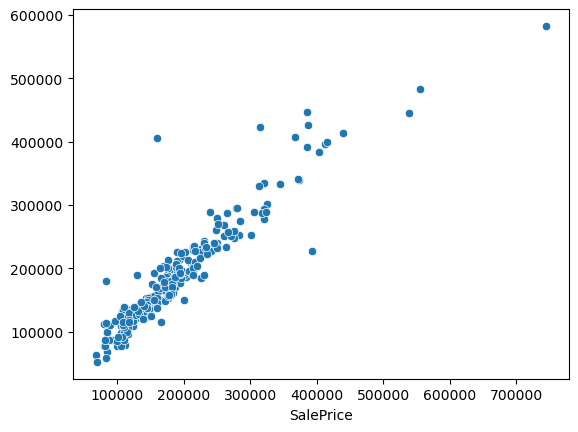

No feature importances function in model

RandomForestRegressor: 
MSE:  805386179.2995247
MAE:  16956.633572249397
MAPE:  0.09319262237441733
R squared: 0.8833762413754188


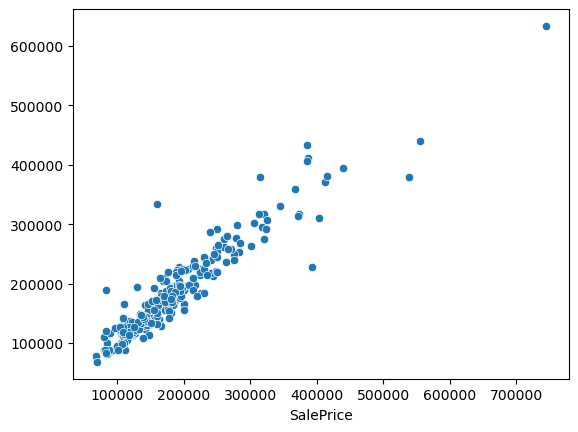

No feature importances function in model

ExtraTreesRegressor:
MSE:  1114111501.6072996
MAE:  18007.546053174512
MAPE:  0.09403768967179828
R squared: 0.8386713427869769


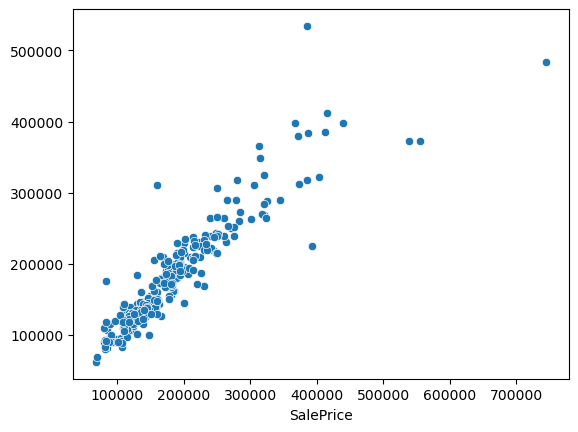

No feature importances function in model

BaggingRegressor: 
MSE:  1086776462.8543575
MAE:  19250.494779904242
MAPE:  0.1050661218281242
R squared: 0.8426295867244248


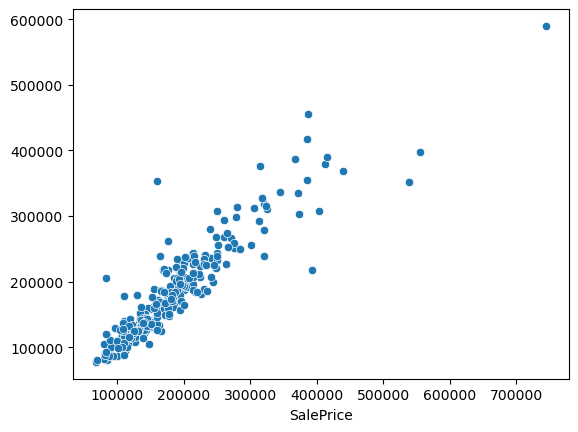

No feature importances function in model

GradientBoostingRegressor: 
MSE:  640495162.8400542
MAE:  15797.623632082601
MAPE:  0.08906211254557578
R squared: 0.9072532467142196


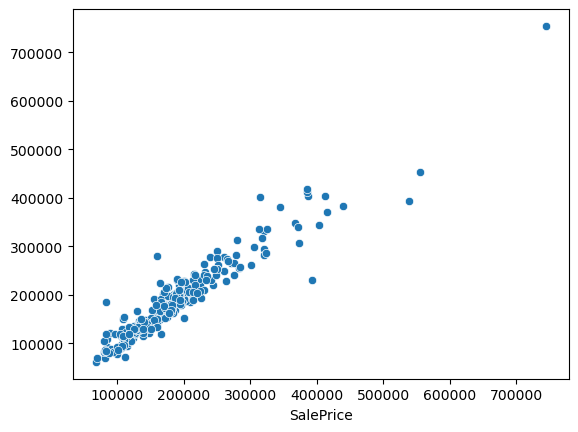

No feature importances function in model


,Model,MSE,MAE,MAPE,R2
0,HistGradientBoostingRegressor:,8.102659e+08,16235.125508,0.091500,0.882670
0,RandomForestRegressor:,8.053862e+08,16956.633572,0.093193,0.883376
0,ExtraTreesRegressor:,1.114112e+09,18007.546053,0.094038,0.838671
0,BaggingRegressor:,1.086776e+09,19250.494780,0.105066,0.842630
0,GradientBoostingRegressor:,6.404952e+08,15797.623632,0.089062,0.907253


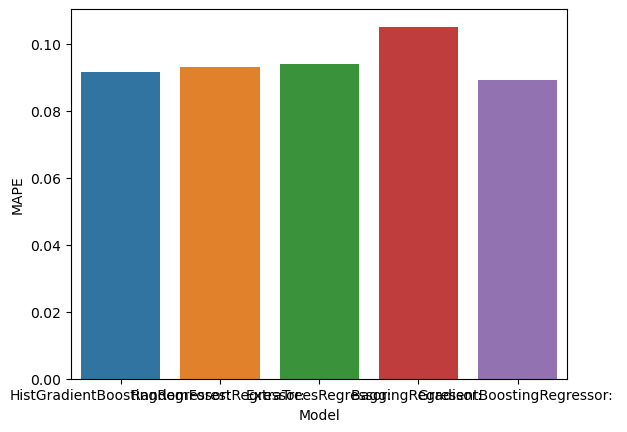

In [25]:
def multiregressor():

    scoresdf = pd.DataFrame(columns = ['Model', 'MSE', 'MAE', 'MAPE'])

    for model_name,curr_model in models :
        curr_model.random_state = 78
    
        #curr_model.fit(X_train, y_train)
        #preds = curr_model.predict(X_test)

        regr_trans = TransformedTargetRegressor(regressor=curr_model, transformer=QuantileTransformer(n_quantiles=200, output_distribution="normal"))
        #regr_trans = TransformedTargetRegressor(regressor=curr_model, func=np.log, inverse_func=np.exp)
        #regr_trans = TransformedTargetRegressor(regressor=curr_model, transformer=PowerTransformer())
        regr_trans.fit(X_train, y_train)
        preds = regr_trans.predict(X_test)
        MSE = mean_squared_error(y_test, preds)
        MAE = mean_absolute_error(y_test, preds)
        MAPE = mean_absolute_percentage_error(y_test, preds)
        R2 = r2_score(y_test, preds)
        print()
        print(model_name)
        print('MSE: ', MSE)
        print('MAE: ', MAE)
        print('MAPE: ', MAPE)
        print('R squared:', R2)
        sns.scatterplot(x = y_test, y = preds)
        plt.show()
        new_row = {'Model': model_name, 'MAE': MAE, 'MSE':MSE, 'MAPE':MAPE, 'R2':R2}
        scoresdf = pd.concat([scoresdf, pd.DataFrame.from_records([new_row])])
        try:
            skplt.estimators.plot_feature_importances(curr_model, feature_names=cols, x_tick_rotation = 90, max_num_features = 30)
            plt.show()
        except:
            print("No feature importances function in model") 
    sns.barplot(data=scoresdf, x="Model", y="MAPE")
    return scoresdf

multiregressor()

In [26]:
# Run for CV, go walk the dog.

from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score, ShuffleSplit

def kfoldmodel():
    cv = ShuffleSplit(n_splits=20, random_state=0)

    scoresdf = pd.DataFrame(columns = ['model', 'mean score'])

    for name,curr_model in models:
        print()
        print (name)
        pipeline = Pipeline([('scaler', scaler), ('model', curr_model)])
        scores = cross_val_score(pipeline, X, y, cv=cv)
        print("Fold scores:", scores)
        meanscore = scores.mean()
        print("Average score: ", meanscore)
        new_row = {'model':name, 'mean score':meanscore}
        #scoresdf = scoresdf.append(new_row, ignore_index=True)
        scoresdf = pd.concat([scoresdf, pd.DataFrame.from_records([new_row])])
    return scoresdf

kfoldmodel()


HistGradientBoostingRegressor:
Fold scores: [0.84920799 0.86509396 0.87219772 0.90616031 0.81898664 0.87088003
 0.89205388 0.90360634 0.86683107 0.92086654 0.92204007 0.87512945
 0.72292705 0.87057764 0.91010722 0.91622591 0.81301242 0.88940866
 0.93118076 0.86019198]
Average score:  0.8738342806577789

RandomForestRegressor: 
Fold scores: [0.87819686 0.8632547  0.87191956 0.89178666 0.82247916 0.8758565
 0.87902608 0.87910529 0.86735114 0.91725854 0.9022551  0.8893212
 0.70151104 0.89887635 0.9191184  0.90304203 0.79728598 0.87032438
 0.92231053 0.87632523]
Average score:  0.8713302369906548

ExtraTreesRegressor:
Fold scores: [0.86244469 0.84995248 0.87761866 0.9006057  0.8579715  0.85479718
 0.87006776 0.89220514 0.89395162 0.89293415 0.88694413 0.87928075
 0.79351274 0.88137593 0.93086244 0.91881847 0.82639439 0.87875007
 0.93252873 0.86858494]
Average score:  0.877480072963165

BaggingRegressor: 
Fold scores: [0.85611721 0.83942853 0.87982393 0.89790699 0.78444601 0.8804036
 0.885

,model,mean score
0,HistGradientBoostingRegressor:,0.873834
0,RandomForestRegressor:,0.871330
0,ExtraTreesRegressor:,0.877480
0,BaggingRegressor:,0.853004
0,GradientBoostingRegressor:,0.899835


0 	HistGradientBoostingRegressor: 	0.872896
1 	RandomForestRegressor: 	0.873884
2 	ExtraTreesRegressor: 	0.881244
3 	BaggingRegressor: 	0.849495
4 	GradientBoostingRegressor: 	0.898029

In [28]:
#from autosklearn.experimental.askl2 import AutoSklearn2Regressor

import autosklearn.regression

automl = autosklearn.regression.AutoSklearnRegressor(
    time_left_for_this_task=60,
    per_run_time_limit=10)

# define search
#model = AutoSklearn2Regressor()
# perform the search
automl.fit(X_train, y_train)

ModuleNotFoundError: No module named 'autosklearn'

In [ ]:
print('Train score:', model.score(X_train, y_train))
print('Test score:', model.score(X_test, y_test))